In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
from dagger.graph import DAG, _calc_prior_discrete, _group_probs
from dagger.common import make_fake_df, normalise

In [3]:
df = pd.DataFrame({"a": [1, 1, 1, 1, 0, 0, 0, 0], 
                   "b": [0, 1, 0, 1, 1, 1, 1, 0], 
                   "c": [0, 0, 1, 0, 0, 1, 0, 1],
                   "d": [1, 1, 0, 1, 0, 0, 0, 0],
                   "e": [1, 1, 1, 1, 0, 0, 0, 0]})
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "b")
dag.merge_probs

<bound method DAG.merge_probs of <dagger.graph.DAG object at 0x12d06c8d0>>

In [4]:
def merge_probs(this_one, other):
    common_cols = list(set(this_one.columns)
                       .intersection(set(other.columns))
                       .difference({"prob"}))
    if len(common_cols) == 0:
        columns = set(other.columns).difference({"prob"})
        loose_tables = []
        for c in columns:
            for value in dag.calc_node_table(c)[c].values:
                loose_tables.append(this_one.assign(**{c: value}))
        join_able = pd.concat(loose_tables)
        return merge_probs(join_able, other)
    return (this_one
            .set_index(common_cols)
            .join(other.set_index(common_cols), lsuffix="1", rsuffix="2")
            .assign(prob=lambda x: normalise(x.prob1 * x.prob2))
            .drop("prob1", axis=1)
            .drop("prob2", axis=1)
            .reset_index())

this_one = (dag.calc_node_table("a")
            .pipe(dag.merge_probs, that_df=dag.calc_node_table("b"))
            .pipe(dag.merge_probs, that_df=dag.calc_node_table("c"))
            .pipe(dag.merge_probs, that_df=dag.calc_node_table("d"))
            .pipe(dag.merge_probs, that_df=dag.calc_node_table("e")))

(this_one
     .groupby(['e'])['prob'].mean()
     .reset_index()
     .assign(prob=lambda d: normalise(d.prob))
     .to_dict("list"))

{'e': [0, 1], 'prob': [0.5, 0.5]}

In [27]:
a = this_one.sort_values(["a", "b", "c", "d", "e"]).reset_index().drop("index", axis=1)
b = dag.marginal_table.sort_values(["a", "b", "c", "d", "e"]).reset_index().drop("index", axis=1)

a.shape, a.merge(b).shape

((24, 6), (24, 6))

In [25]:
nodes_done = [] 
starting_node = list(dag.graph.nodes())[0]
all_probs = dag.calc_node_table(starting_node)
nodes_done.append(starting_node)
while set(nodes_done) != set(dag.graph.nodes()):
    for n in nodes_done:
        for c in dag.connections(n):
            if c in nodes_done: 
                break
            node_prob = dag.calc_node_table(c)
            parents = dag.connections(c)
            all_probs = merge_probs(all_probs, node_prob, parents=parents)
            nodes_done.append(c)
print(all_probs)

TypeError: unhashable type: 'set'

In [7]:
dag.calc_node_table("b")

,a,b,count,prob
0,0,0,1,0.125
1,0,1,3,0.375
2,1,0,2,0.250
3,1,1,2,0.250


In [10]:
merge_probs(dag.calc_node_table("b"), dag.calc_node_table("a"), "a")

{'a'}
set()


AttributeError: 'DataFrame' object has no attribute 'p1'

In [59]:
def _calc_probs(dataf, groups):
    return (dataf
            .assign(n=1)
            .groupby(groups)
            .count()['n']
            .reset_index()
            .assign(p=lambda d: d.n / d.n.sum()))

graph = dag.graph.copy()
prob_container = {c: _calc_probs(dag._df, c) for c in dag._df.columns}
while len(prob_container.keys()) > 1:
    next_node = (dag.no_parent_nodes(graph) + dag.leaf_nodes(graph))[0]
    parents = list(graph.predecessors(next_node))
    print(f"\npicked node: '{next_node}' with parents: {parents}")
    for child in list(graph.successors(next_node)) + list(graph.predecessors(next_node)):
            print(f"child: {child}, groups: {[next_node] + parents}")
        prob_container[child] = _calc_probs(dag._df, [next_node] + parents)
        print(prob_container[child])
    del prob_container[next_node]
    print(new_probs)
    prob_df = prob_df.merge(new_probs)
    print(prob_df)
    graph.remove_node(next_node)



picked node: 'a' with parents: []
child: b, groups: ['a']
   a  n    p
0  0  4  0.5
1  1  4  0.5
child: c, groups: ['a']
   a  n    p
0  0  4  0.5
1  1  4  0.5
   c  n      p
0  0  5  0.625
1  1  3  0.375
Empty DataFrame
Columns: [a, b, c, n, p]
Index: []

picked node: 'b' with parents: []
   c  n      p
0  0  5  0.625
1  1  3  0.375
Empty DataFrame
Columns: [a, b, c, n, p]
Index: []


In [11]:
nodes_done = set()
distributions = {}
nodes_to_do = set(dag._priors.keys())
prior_copy = dag._priors.copy()
while nodes_done != set(dag.graph.nodes):
    current_root_nodes = get_root_nodes(dag, nodes_done)
    for node in current_root_nodes:
        parents = list(dag.graph.predecessors(node))
        prob_df = (df
                   .assign(n=1)
                   .groupby(parents + [node])
                   .count()['n']
                   .reset_index()
                   .assign(p=lambda d: d.n/d.n.sum()))
        if len(parents) != 0:
            prob_df = prob_df.pipe(_group_probs, parents=parents)
        else:
            prob_df = prob_df.drop(columns=["n"])
        distributions[node] = prob_df
        nodes_done.add(node)
prob_df

,a,c,b,p
0,0,0,0,0.500000
1,0,0,1,0.500000
2,0,1,0,1.000000
3,1,0,0,0.333333
4,1,0,1,0.666667
5,1,1,0,1.000000


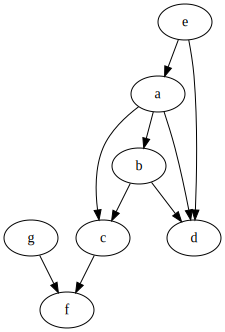

In [15]:
dag = (DAG(make_fake_df(7))
       .add_edge("e", "a")
       .add_edge("e", "d")
       .add_edge("a", "d")
       .add_edge("b", "d")
       .add_edge("a", "b")
       .add_edge("a", "c")
       .add_edge("b", "c")
       .add_edge("c", "f")
       .add_edge("g", "f"))

dag.plot()

In [16]:
dag.independences()

In [17]:
dag.prob_data_frame()

   g   n     p
0  0  48  0.48
1  1  52  0.52
Empty DataFrame
Columns: [f, c, n, p, g]
Index: []
Empty DataFrame
Columns: [e, n, p, f, c, g]
Index: []
Empty DataFrame
Columns: [a, n, p, e, f, c, g]
Index: []
Empty DataFrame
Columns: [c, b, n, p, a, e, f, g]
Index: []
Empty DataFrame
Columns: [b, n, p, c, a, e, f, g]
Index: []
Empty DataFrame
Columns: [d, n, p, b, c, a, e, f, g]
Index: []


In [10]:
# nodes_done = set()

# current_leaf_nodes = get_leaf_nodes(dag, nodes_done)
# model_df = distributions[current_leaf_nodes[0]]
# while nodes_done != set(dag.graph.nodes):
#     current_leaf_nodes = get_leaf_nodes(dag, nodes_done)
#     for node in current_leaf_nodes:
#         parents = list(dag.graph.predecessors(node))
#         for p in parents:
#             print(f"node={node}, parents={parents}, parent={p}")
#             print(model_df)
#             print(distributions[p])
#             model_df = merge_probs(model_df, distributions[p], p)
#             print(model_df)
#             if len(list(dag.graph.predecessors(p))) == 0:
#                 nodes_done.add(p)
#         nodes_done.add(node)

# model_df

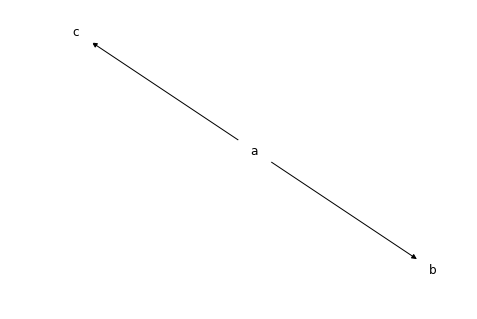

In [11]:
dag.nx_plot(node_size=1500, with_labels=True, node_color="white")

In [12]:
list(dag.parents("a")), list(dag.parents("b")), list(dag.parents("c"))

([], ['a'], ['a'])